# Prepare Ross Ice Shelf gravity data

import the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
from antarctic_plots import fetch, regions, utils, maps
import pygmt
import numpy as np
import pandas as pd
import numpy as np
from scipy import stats
import geopandas as gpd
import xarray as xr
import rioxarray
import verde as vd
import harmonica as hm
from pyproj import Transformer
import os
import zarr
import math
import scipy
import warnings
from tqdm.auto import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from RIS_gravity_inversion import gravity_processing as grav
from RIS_gravity_inversion import utils as inv_utils

os.getcwd()

'/Users/home/tankerma/RIS_gravity_inversion/notebooks'

# ROSETTA-Ice data

## load raw data
with antarctic_plots.fetch

line       LATITUDE      LONGITUDE      unixtime  \
count  398279.000000  398279.000000  398279.000000  3.982790e+05   
mean      661.219550     -80.571198     -36.741857  1.457515e+09   
std       264.422153       1.786949     165.241996  1.431469e+07   
min        20.000000     -85.389220    -179.999880  1.447367e+09   
25%       470.000000     -81.869075    -169.885715  1.448316e+09   
50%       650.000000     -80.392556    -158.359371  1.449134e+09   
75%       840.000000     -79.145016     171.037900  1.479949e+09   
max      1140.000000     -77.339971     180.000724  1.480734e+09   

              Height        easting      northing  FAG_levelled  
count  398279.000000  398279.000000  3.982790e+05  3.982790e+05  
mean      793.056619  -84278.810943 -1.000705e+06  4.329633e-15  
std        83.977581  212966.781186  1.984653e+05  1.425479e+01  
min       650.023000 -571781.809097 -1.367767e+06 -2.854953e+02  
25%       744.524000 -240585.860838 -1.160510e+06 -7.364494e+00  
50%       774.652000  -78622.827092 -1.010417e+06  2.097471e-01  
75%       819.844000   80843.853800 -8.504463e+05  7.961177e+00  
max      1377.258000  371757.426732 -4.604543e+05  7.619118e+01

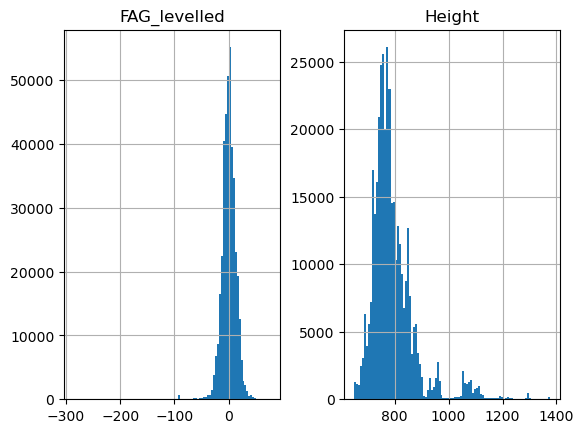

In [2]:
rosetta = fetch.ROSETTA_gravity()

# set standard column names
rosetta = rosetta.rename(columns={"Line": "line", "x": "easting", "y": "northing"})

# rosetta = gpd.GeoDataFrame(
#     rosetta,
#     geometry=gpd.points_from_xy(x=rosetta.easting, y=rosetta.northing),
# )
rosetta.dropna(subset="FAG_levelled", inplace=True)
rosetta[["FAG_levelled", "Height"]].hist(bins=100)
rosetta.describe()

## load cleaned and upward continued data from notebook `ROSETTA_levelling`

In [3]:
rosetta_UC = pd.read_csv(
    "../data/ROSETTA_UC.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
rosetta_UC.dropna(subset="FAG_levelled", inplace=True)
rosetta_UC.describe()

easting      northing          line      LATITUDE     LONGITUDE  \
count   38106.000000  3.810600e+04  38106.000000  37243.000000  37243.000000   
mean   -86452.716611 -1.000882e+06    666.940141    -80.569377    -37.553185   
std    212319.269750  1.978192e+05    266.106586      1.782562    164.975209   
min   -571286.658609 -1.367282e+06     20.000000    -85.387441   -179.978599   
25%   -241920.367902 -1.160507e+06    470.000000    -81.858765   -169.879744   
50%    -80109.153154 -1.010449e+06    650.000000    -80.379084   -158.354158   
75%     75505.628018 -8.504463e+05    850.000000    -79.151582    171.015026   
max    371296.853790 -4.604545e+05   1140.000000    -77.344218    179.979597   

           unixtime        Height  FAG_levelled  dist_along_line  \
count  3.724300e+04  38106.000000  38106.000000     38106.000000   
mean   1.457282e+09    793.380839      0.178232    330776.624441   
std    1.419616e+07     84.595750     13.828917    220867.316758   
min    1.447367e+09    650.085400   -285.495212       228.712147   
25%    1.448316e+09    744.647838     -7.261404    143461.769673   
50%    1.449134e+09    774.987318      0.247913    303380.605696   
75%    1.479948e+09    820.050591      7.950586    492611.668244   
max    1.480734e+09   1376.838556     75.203892    908258.425261   

       mistie_before_UC  intersecting_line  up_cont_grav           dif  \
count       1704.000000         852.000000  38106.000000  38106.000000   
mean           0.284638         815.623239      0.201990      0.023758   
std            5.206815         286.885417     13.190412      1.425300   
min          -39.323652          50.000000   -227.512365    -20.999761   
25%           -1.794086         570.000000     -7.076050     -0.366643   
50%            0.201308         955.000000      0.205302      0.000686   
75%            1.797093        1070.000000      7.790776      0.353437   
max           40.569202        1140.000000     65.843562     75.200788   

       mistie_after_UC  
count       852.000000  
mean          0.195705  
std           4.856286  
min         -31.132140  
25%          -1.738407  
50%           0.035426  
75%           1.910585  
max          39.348110

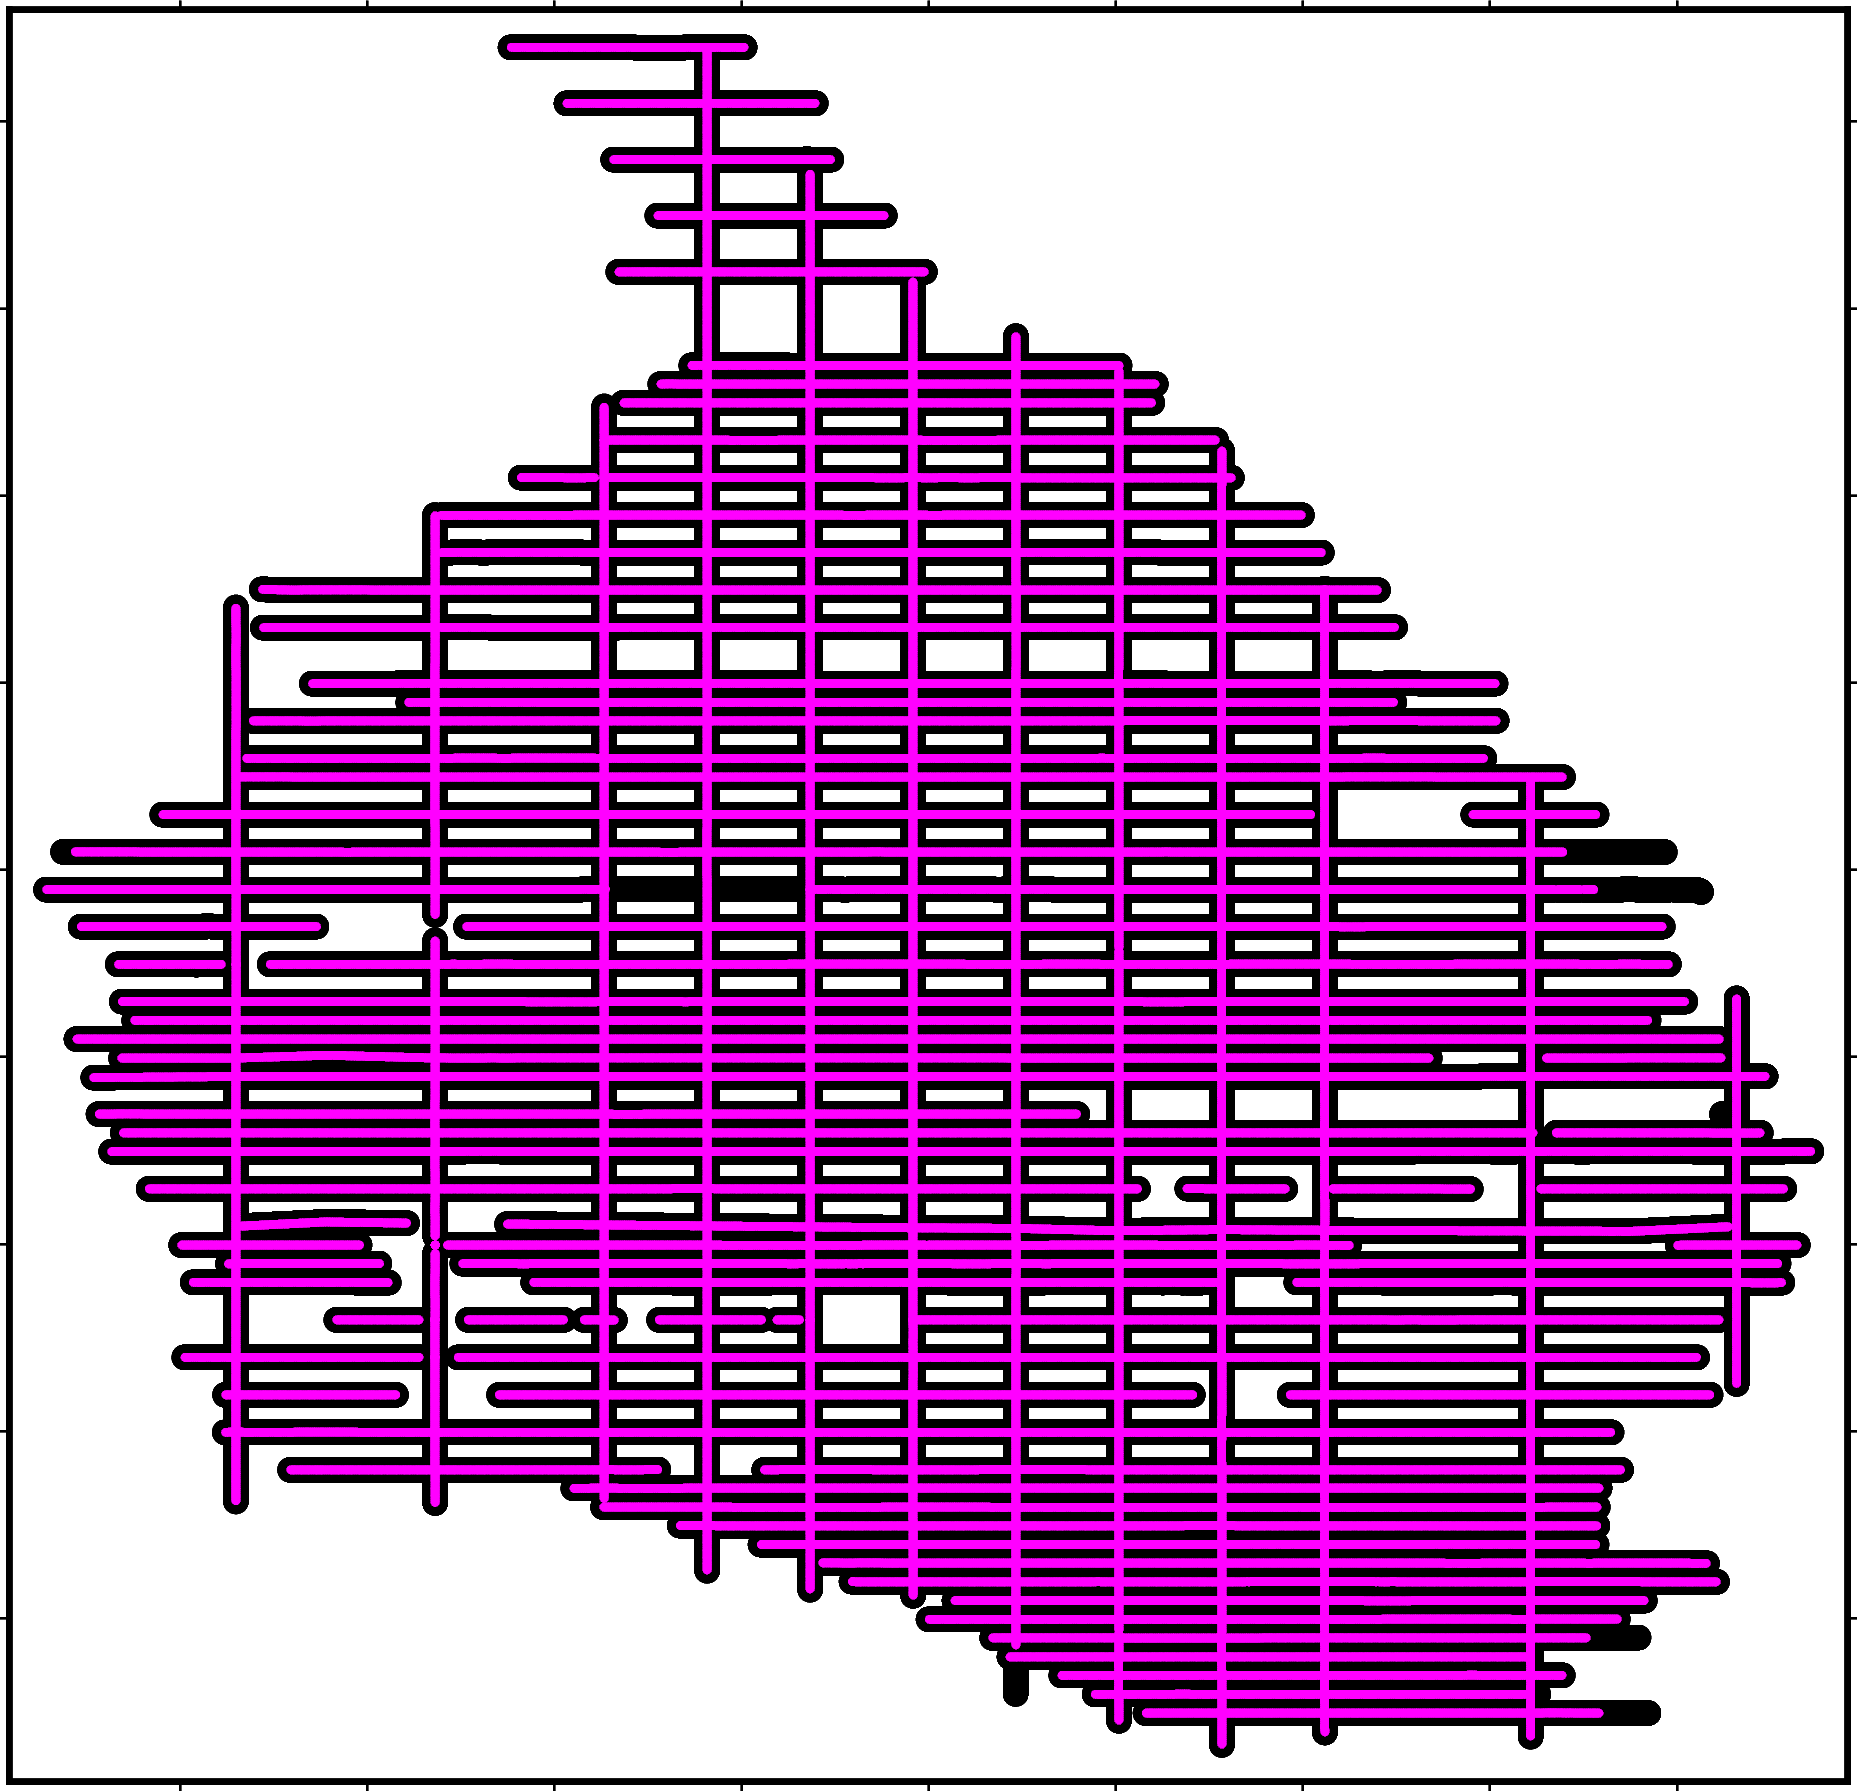

In [4]:
# plot a basemap
fig = maps.basemap(
    region=vd.pad_region(
        vd.get_region((rosetta_UC.easting, rosetta_UC.northing)), 20e3
    ),
    # background="black",
)

# plot gravity data
fig.plot(
    x=rosetta.easting,
    y=rosetta.northing,
    style="c6p",
    fill="black",
)

# plot gravity data
fig.plot(
    x=rosetta_UC.easting,
    y=rosetta_UC.northing,
    style="c2p",
    fill="magenta",
)

fig.show()

## Grid with Equivalent Sources
at half the desired spacing to create the test and training sets

In [5]:
# coords = (rosetta_UC.easting, rosetta_UC.northing, np.ones_like(rosetta_UC.northing) * 1e3)
# data = rosetta_UC.up_cont_grav

# study_df, eqs = inv_utils.optimize_eq_source_params(
#     coords,
#     data,
#     n_trials=3,
#     damping_limits=[0, 1e3],
#     depth_limits=[0, 40e3],
#     # parallel=True,
#     fname="tmp",
#     # use_existing=True,
#     plot=True,
#     block_size=2e3,
# )

In [6]:
# # Define grid coordinates
# region = vd.pad_region(vd.get_region(coords), 20e3)
# grid_coords = vd.grid_coordinates(
#     region=region,
#     spacing=5e3 / 2,
#     extra_coords=1e3,  # upward continue to 1km
# )

# # Predict values at obs points
# # rosetta_UC["full_grd_UC"] = eqs.predict(coords)
# # rosetta_UC.describe()

# # Grid the gravity disturbances
# grid = eqs.grid(grid_coords, data_names=["Gobs"])

# grav_df = vd.grid_to_table(grid)

# # resample to half spacing to make training / testing points
# grav_df = inv_utils.resample_with_test_points(
#     5e3, grav_df, region)

# masked = vd.distance_mask((rosetta_UC.easting, rosetta_UC.northing), maxdist=20e3, grid=grid)
# masked = masked.reset_coords(names="upward")
# masked.Gobs.plot(robust=True)

In [7]:
# eqs = hm.EquivalentSources(damping=1e4, depth=10e3, block_size=2e3)

# coords = (rosetta_UC.easting, rosetta_UC.northing, np.ones_like(rosetta_UC.northing) * 1e3)
# data = rosetta_UC.up_cont_grav

# eqs.fit(coords, data)

In [8]:
# # Define grid coordinates
# region = vd.pad_region(vd.get_region(coords), 20e3)
# grid_coords = vd.grid_coordinates(
#     region=region,
#     spacing=5e3 / 2,
#     extra_coords=1e3,  # upward continue to 1km
# )

# grid = eqs.grid(grid_coords)

# # Predict values at obs points
# # rosetta_UC["full_grd_UC"] = eqs.predict(coords)

# masked = vd.distance_mask((rosetta_UC.easting, rosetta_UC.northing), maxdist=20e3, grid=grid)
# masked = masked.reset_coords(names="upward")
# masked.scalars.plot(robust=True)

In [9]:
# # save to a .zarr file
# grid.to_zarr(
#     "../inversion_layers/rosetta_eq_source_1k_up_continued.zarr",
#     encoding={
#         "Gobs": {"compressor": zarr.Blosc()},
#         "upward": {"compressor": zarr.Blosc()},
#     },
#     mode="w",
# )

In [10]:
# rosetta_eq_source_1k_up_continued = xr.open_zarr("../inversion_layers/rosetta_eq_source_1k_up_continued.zarr")
# rosetta_eq_source_1k_up_continued

# Repeat with first removing outliers

In [11]:
rosetta_UC = pd.read_csv(
    "../data/ROSETTA_UC.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
rosetta_UC.dropna(subset="FAG_levelled", inplace=True)
rosetta_UC.describe()

easting      northing          line      LATITUDE     LONGITUDE  \
count   38106.000000  3.810600e+04  38106.000000  37243.000000  37243.000000   
mean   -86452.716611 -1.000882e+06    666.940141    -80.569377    -37.553185   
std    212319.269750  1.978192e+05    266.106586      1.782562    164.975209   
min   -571286.658609 -1.367282e+06     20.000000    -85.387441   -179.978599   
25%   -241920.367902 -1.160507e+06    470.000000    -81.858765   -169.879744   
50%    -80109.153154 -1.010449e+06    650.000000    -80.379084   -158.354158   
75%     75505.628018 -8.504463e+05    850.000000    -79.151582    171.015026   
max    371296.853790 -4.604545e+05   1140.000000    -77.344218    179.979597   

           unixtime        Height  FAG_levelled  dist_along_line  \
count  3.724300e+04  38106.000000  38106.000000     38106.000000   
mean   1.457282e+09    793.380839      0.178232    330776.624441   
std    1.419616e+07     84.595750     13.828917    220867.316758   
min    1.447367e+09    650.085400   -285.495212       228.712147   
25%    1.448316e+09    744.647838     -7.261404    143461.769673   
50%    1.449134e+09    774.987318      0.247913    303380.605696   
75%    1.479948e+09    820.050591      7.950586    492611.668244   
max    1.480734e+09   1376.838556     75.203892    908258.425261   

       mistie_before_UC  intersecting_line  up_cont_grav           dif  \
count       1704.000000         852.000000  38106.000000  38106.000000   
mean           0.284638         815.623239      0.201990      0.023758   
std            5.206815         286.885417     13.190412      1.425300   
min          -39.323652          50.000000   -227.512365    -20.999761   
25%           -1.794086         570.000000     -7.076050     -0.366643   
50%            0.201308         955.000000      0.205302      0.000686   
75%            1.797093        1070.000000      7.790776      0.353437   
max           40.569202        1140.000000     65.843562     75.200788   

       mistie_after_UC  
count       852.000000  
mean          0.195705  
std           4.856286  
min         -31.132140  
25%          -1.738407  
50%           0.035426  
75%           1.910585  
max          39.348110

## remove outliers

Length of original data: 38106
Length of cleaned data: 37764


<Axes: >

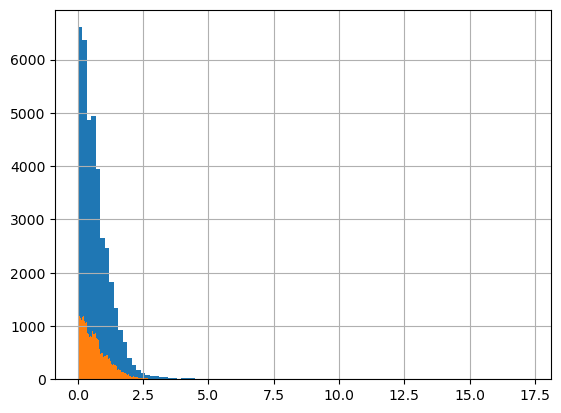

In [12]:
rosetta_UC["zscore"] = np.abs(stats.zscore(rosetta_UC.up_cont_grav))
rosetta_UC.sort_values(by="zscore", ascending=False, inplace=True)
rosetta_UC.zscore.hist(bins=100)

# dropped base on z-score
df_cleaned = rosetta_UC[rosetta_UC.zscore < 3].copy()
df_outliers = rosetta_UC[rosetta_UC.zscore >= 3].copy()

print("Length of original data:", len(rosetta_UC))
print("Length of cleaned data:", len(df_cleaned))

df_cleaned.zscore.hist(bins=100)

In [13]:
df_cleaned.describe()

easting      northing          line      LATITUDE     LONGITUDE  \
count   37764.000000  3.776400e+04  37764.000000  36908.000000  36908.000000   
mean   -85400.520583 -1.002386e+06    668.840721    -80.556630    -36.899157   
std    212184.613783  1.957472e+05    263.894722      1.763942    165.197216   
min   -571286.658609 -1.367282e+06     20.000000    -85.387441   -179.978599   
25%   -239325.061391 -1.160508e+06    470.000000    -81.837372   -169.966223   
50%    -77516.708260 -1.010453e+06    650.000000    -80.377141   -158.320659   
75%     76335.715985 -8.504515e+05    850.000000    -79.149656    171.099147   
max    371296.853790 -4.604545e+05   1140.000000    -77.344218    179.979597   

           unixtime        Height  FAG_levelled  dist_along_line  \
count  3.690800e+04  37764.000000  37764.000000     37764.000000   
mean   1.457193e+09    792.262277      0.441192    332231.546831   
std    1.414757e+07     82.795326     11.628830    220466.506726   
min    1.447367e+09    650.085400    -49.066601       228.712147   
25%    1.448316e+09    744.448629     -7.162919    145505.732832   
50%    1.449134e+09    774.596062      0.279251    304675.166416   
75%    1.479947e+09    818.931748      7.900701    494263.811127   
max    1.480734e+09   1376.838556     46.177935    908258.425261   

       mistie_before_UC  intersecting_line  up_cont_grav           dif  \
count       1696.000000         848.000000  37764.000000  37764.000000   
mean           0.169587         814.989387      0.446640      0.005448   
std            4.870670         287.173849     11.249334      0.914507   
min          -39.323652          50.000000    -39.318698    -12.759754   
25%           -1.799649         570.000000     -6.980712     -0.365907   
50%            0.176075         910.000000      0.240532     -0.001326   
75%            1.764063        1070.000000      7.751647      0.346499   
max           40.569202        1140.000000     39.734492     15.853382   

       mistie_after_UC        zscore  
count       848.000000  37764.000000  
mean          0.081608      0.667407  
std           4.504858      0.531280  
min         -31.132140      0.000040  
25%          -1.745752      0.244361  
50%           0.028438      0.555899  
75%           1.846049      0.961299  
max          39.348110      2.997103

Plot outliers and cleaned gravity data

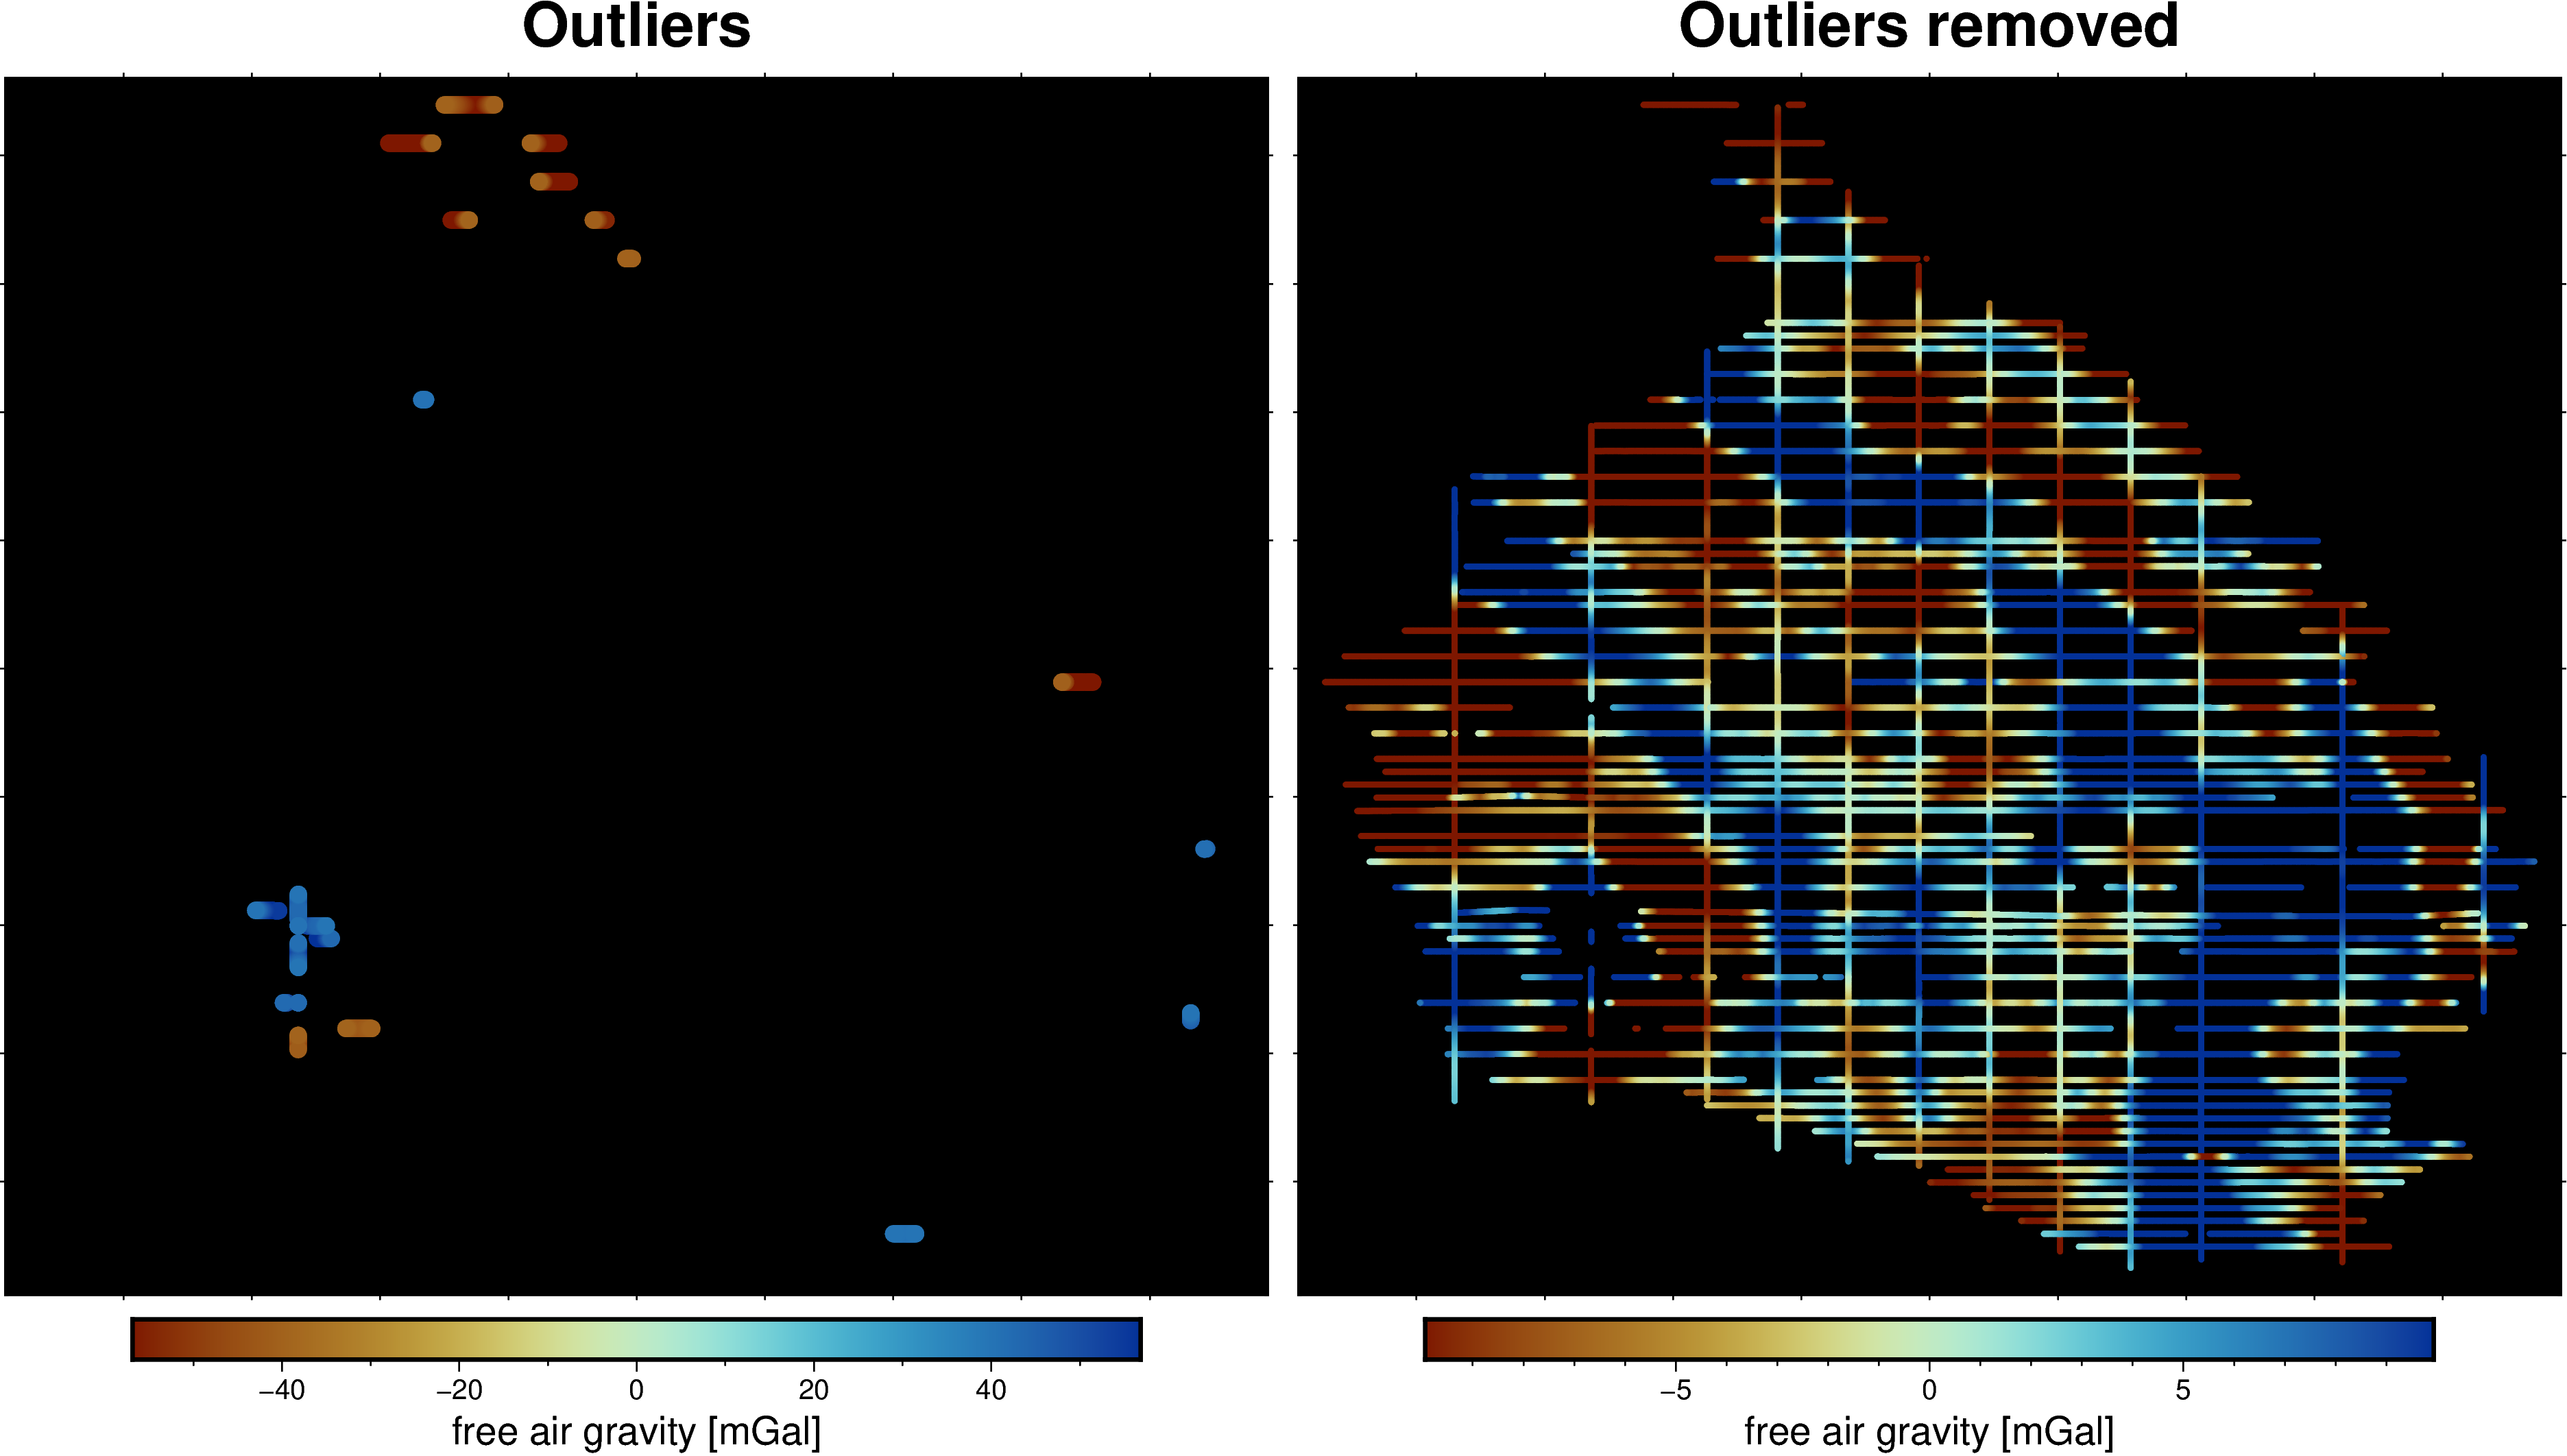

In [14]:
# plot a basemap
region = vd.pad_region(vd.get_region((rosetta_UC.easting, rosetta_UC.northing)), 20e3)
fig = maps.basemap(
    region,
    title="Outliers",
    background="black",
)

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df_outliers.up_cont_grav) * 0.25
pygmt.makecpt(cmap="roma", series=[-maxabs, maxabs])

# plot gravity data
fig.plot(
    x=df_outliers.easting,
    y=df_outliers.northing,
    color=df_outliers.up_cont_grav,
    style="c6p",
    cmap=True,
)

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')


# add a second figure to the right
fig = maps.basemap(
    region,
    title="Outliers removed",
    origin_shift="xshift",
    fig=fig,
    background="black",
)

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df_cleaned.up_cont_grav) * 0.25
pygmt.makecpt(cmap="roma", series=[-maxabs, maxabs])

# plot gravity data
fig.plot(
    x=df_cleaned.easting,
    y=df_cleaned.northing,
    color=df_cleaned.up_cont_grav,
    style="c2p",
    cmap=True,
)

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')

fig.show()

## create equivalent sources

In [15]:
eqs = hm.EquivalentSources(damping=10e3, depth=10e3, block_size=2e3)

coords = (
    df_cleaned.easting,
    df_cleaned.northing,
    np.ones_like(df_cleaned.northing) * 1e3,
)
data = df_cleaned.up_cont_grav

eqs.fit(coords, data)

EquivalentSources(block_size=2000.0, damping=10000.0, depth=10000.0)

In [16]:
# Define grid coordinates
# region = vd.pad_region(vd.get_region(coords), 25e3)
region = regions.ross_ice_shelf
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    pixel_register=False,
    extra_coords=1e3,  # upward continue to 1km
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (grid_coords[0], grid_coords[1]),
    data=grid_coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward


grav_df = vd.grid_to_table(observations)

# resample to half spacing to make training / testing points
grav_df = inv_utils.resample_with_test_points(5e3, grav_df, region)

grav_df["Gobs"] = eqs.predict((grav_df.easting, grav_df.northing, grav_df.upward))

grid = grav_df.set_index(["northing", "easting"]).to_xarray()

grav_df["masked"] = vd.distance_mask(
    (df_cleaned.easting, df_cleaned.northing),
    maxdist=25e3,
    coordinates=(grav_df.easting, grav_df.northing),
)

grav_df = grav_df[grav_df.masked].drop(columns="masked")
grav_df

northing   easting   test  upward       Gobs
5823   -1390000.0   47500.0   True  1000.0   3.640505
5824   -1390000.0   50000.0  False  1000.0   3.893493
5825   -1390000.0   52500.0   True  1000.0   4.162121
5826   -1390000.0   55000.0  False  1000.0   4.447213
5827   -1390000.0   57500.0   True  1000.0   4.748742
...           ...       ...    ...     ...        ...
181365  -437500.0 -200000.0   True  1000.0 -15.280410
181366  -437500.0 -197500.0   True  1000.0 -15.061267
181367  -437500.0 -195000.0   True  1000.0 -14.795921
181368  -437500.0 -192500.0   True  1000.0 -14.494022
181369  -437500.0 -190000.0   True  1000.0 -14.166404

[92598 rows x 5 columns]

In [17]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_grid

<xarray.Dataset>
Dimensions:   (northing: 382, easting: 397)
Coordinates:
  * northing  (northing) float64 -1.39e+06 -1.388e+06 ... -4.4e+05 -4.375e+05
  * easting   (easting) float64 -5.95e+05 -5.925e+05 ... 3.925e+05 3.95e+05
Data variables:
    test      (northing, easting) object nan nan nan nan nan ... nan nan nan nan
    upward    (northing, easting) float64 nan nan nan nan ... nan nan nan nan
    Gobs      (northing, easting) float64 nan nan nan nan ... nan nan nan nan

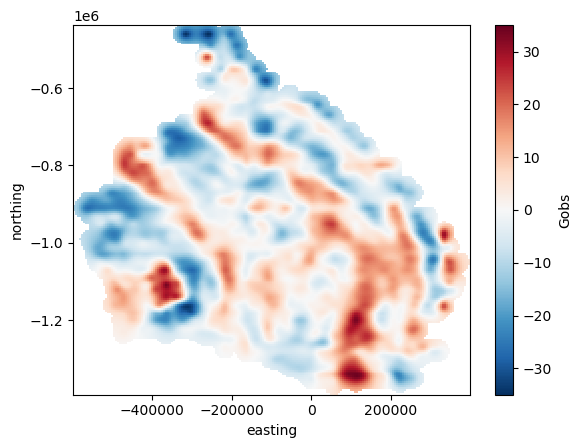

In [18]:
grav_df[grav_df.test == False].set_index(
    ["northing", "easting"]
).to_xarray().Gobs.plot()

In [19]:
grav_df.to_csv(
    "../inversion_layers/rosetta_eq_source_1k_up_continued.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [20]:
grav_df = pd.read_csv(
    "../inversion_layers/rosetta_eq_source_1k_up_continued.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
grav_df

northing   easting   test  upward       Gobs
0     -1390000.0   47500.0   True  1000.0   3.640505
1     -1390000.0   50000.0  False  1000.0   3.893493
2     -1390000.0   52500.0   True  1000.0   4.162121
3     -1390000.0   55000.0  False  1000.0   4.447213
4     -1390000.0   57500.0   True  1000.0   4.748742
...          ...       ...    ...     ...        ...
92593  -437500.0 -200000.0   True  1000.0 -15.280410
92594  -437500.0 -197500.0   True  1000.0 -15.061267
92595  -437500.0 -195000.0   True  1000.0 -14.795921
92596  -437500.0 -192500.0   True  1000.0 -14.494022
92597  -437500.0 -190000.0   True  1000.0 -14.166404

[92598 rows x 5 columns]

In [21]:
df_cleaned.describe()

easting      northing          line      LATITUDE     LONGITUDE  \
count   37764.000000  3.776400e+04  37764.000000  36908.000000  36908.000000   
mean   -85400.520583 -1.002386e+06    668.840721    -80.556630    -36.899157   
std    212184.613783  1.957472e+05    263.894722      1.763942    165.197216   
min   -571286.658609 -1.367282e+06     20.000000    -85.387441   -179.978599   
25%   -239325.061391 -1.160508e+06    470.000000    -81.837372   -169.966223   
50%    -77516.708260 -1.010453e+06    650.000000    -80.377141   -158.320659   
75%     76335.715985 -8.504515e+05    850.000000    -79.149656    171.099147   
max    371296.853790 -4.604545e+05   1140.000000    -77.344218    179.979597   

           unixtime        Height  FAG_levelled  dist_along_line  \
count  3.690800e+04  37764.000000  37764.000000     37764.000000   
mean   1.457193e+09    792.262277      0.441192    332231.546831   
std    1.414757e+07     82.795326     11.628830    220466.506726   
min    1.447367e+09    650.085400    -49.066601       228.712147   
25%    1.448316e+09    744.448629     -7.162919    145505.732832   
50%    1.449134e+09    774.596062      0.279251    304675.166416   
75%    1.479947e+09    818.931748      7.900701    494263.811127   
max    1.480734e+09   1376.838556     46.177935    908258.425261   

       mistie_before_UC  intersecting_line  up_cont_grav           dif  \
count       1696.000000         848.000000  37764.000000  37764.000000   
mean           0.169587         814.989387      0.446640      0.005448   
std            4.870670         287.173849     11.249334      0.914507   
min          -39.323652          50.000000    -39.318698    -12.759754   
25%           -1.799649         570.000000     -6.980712     -0.365907   
50%            0.176075         910.000000      0.240532     -0.001326   
75%            1.764063        1070.000000      7.751647      0.346499   
max           40.569202        1140.000000     39.734492     15.853382   

       mistie_after_UC        zscore  
count       848.000000  37764.000000  
mean          0.081608      0.667407  
std           4.504858      0.531280  
min         -31.132140      0.000040  
25%          -1.745752      0.244361  
50%           0.028438      0.555899  
75%           1.846049      0.961299  
max          39.348110      2.997103

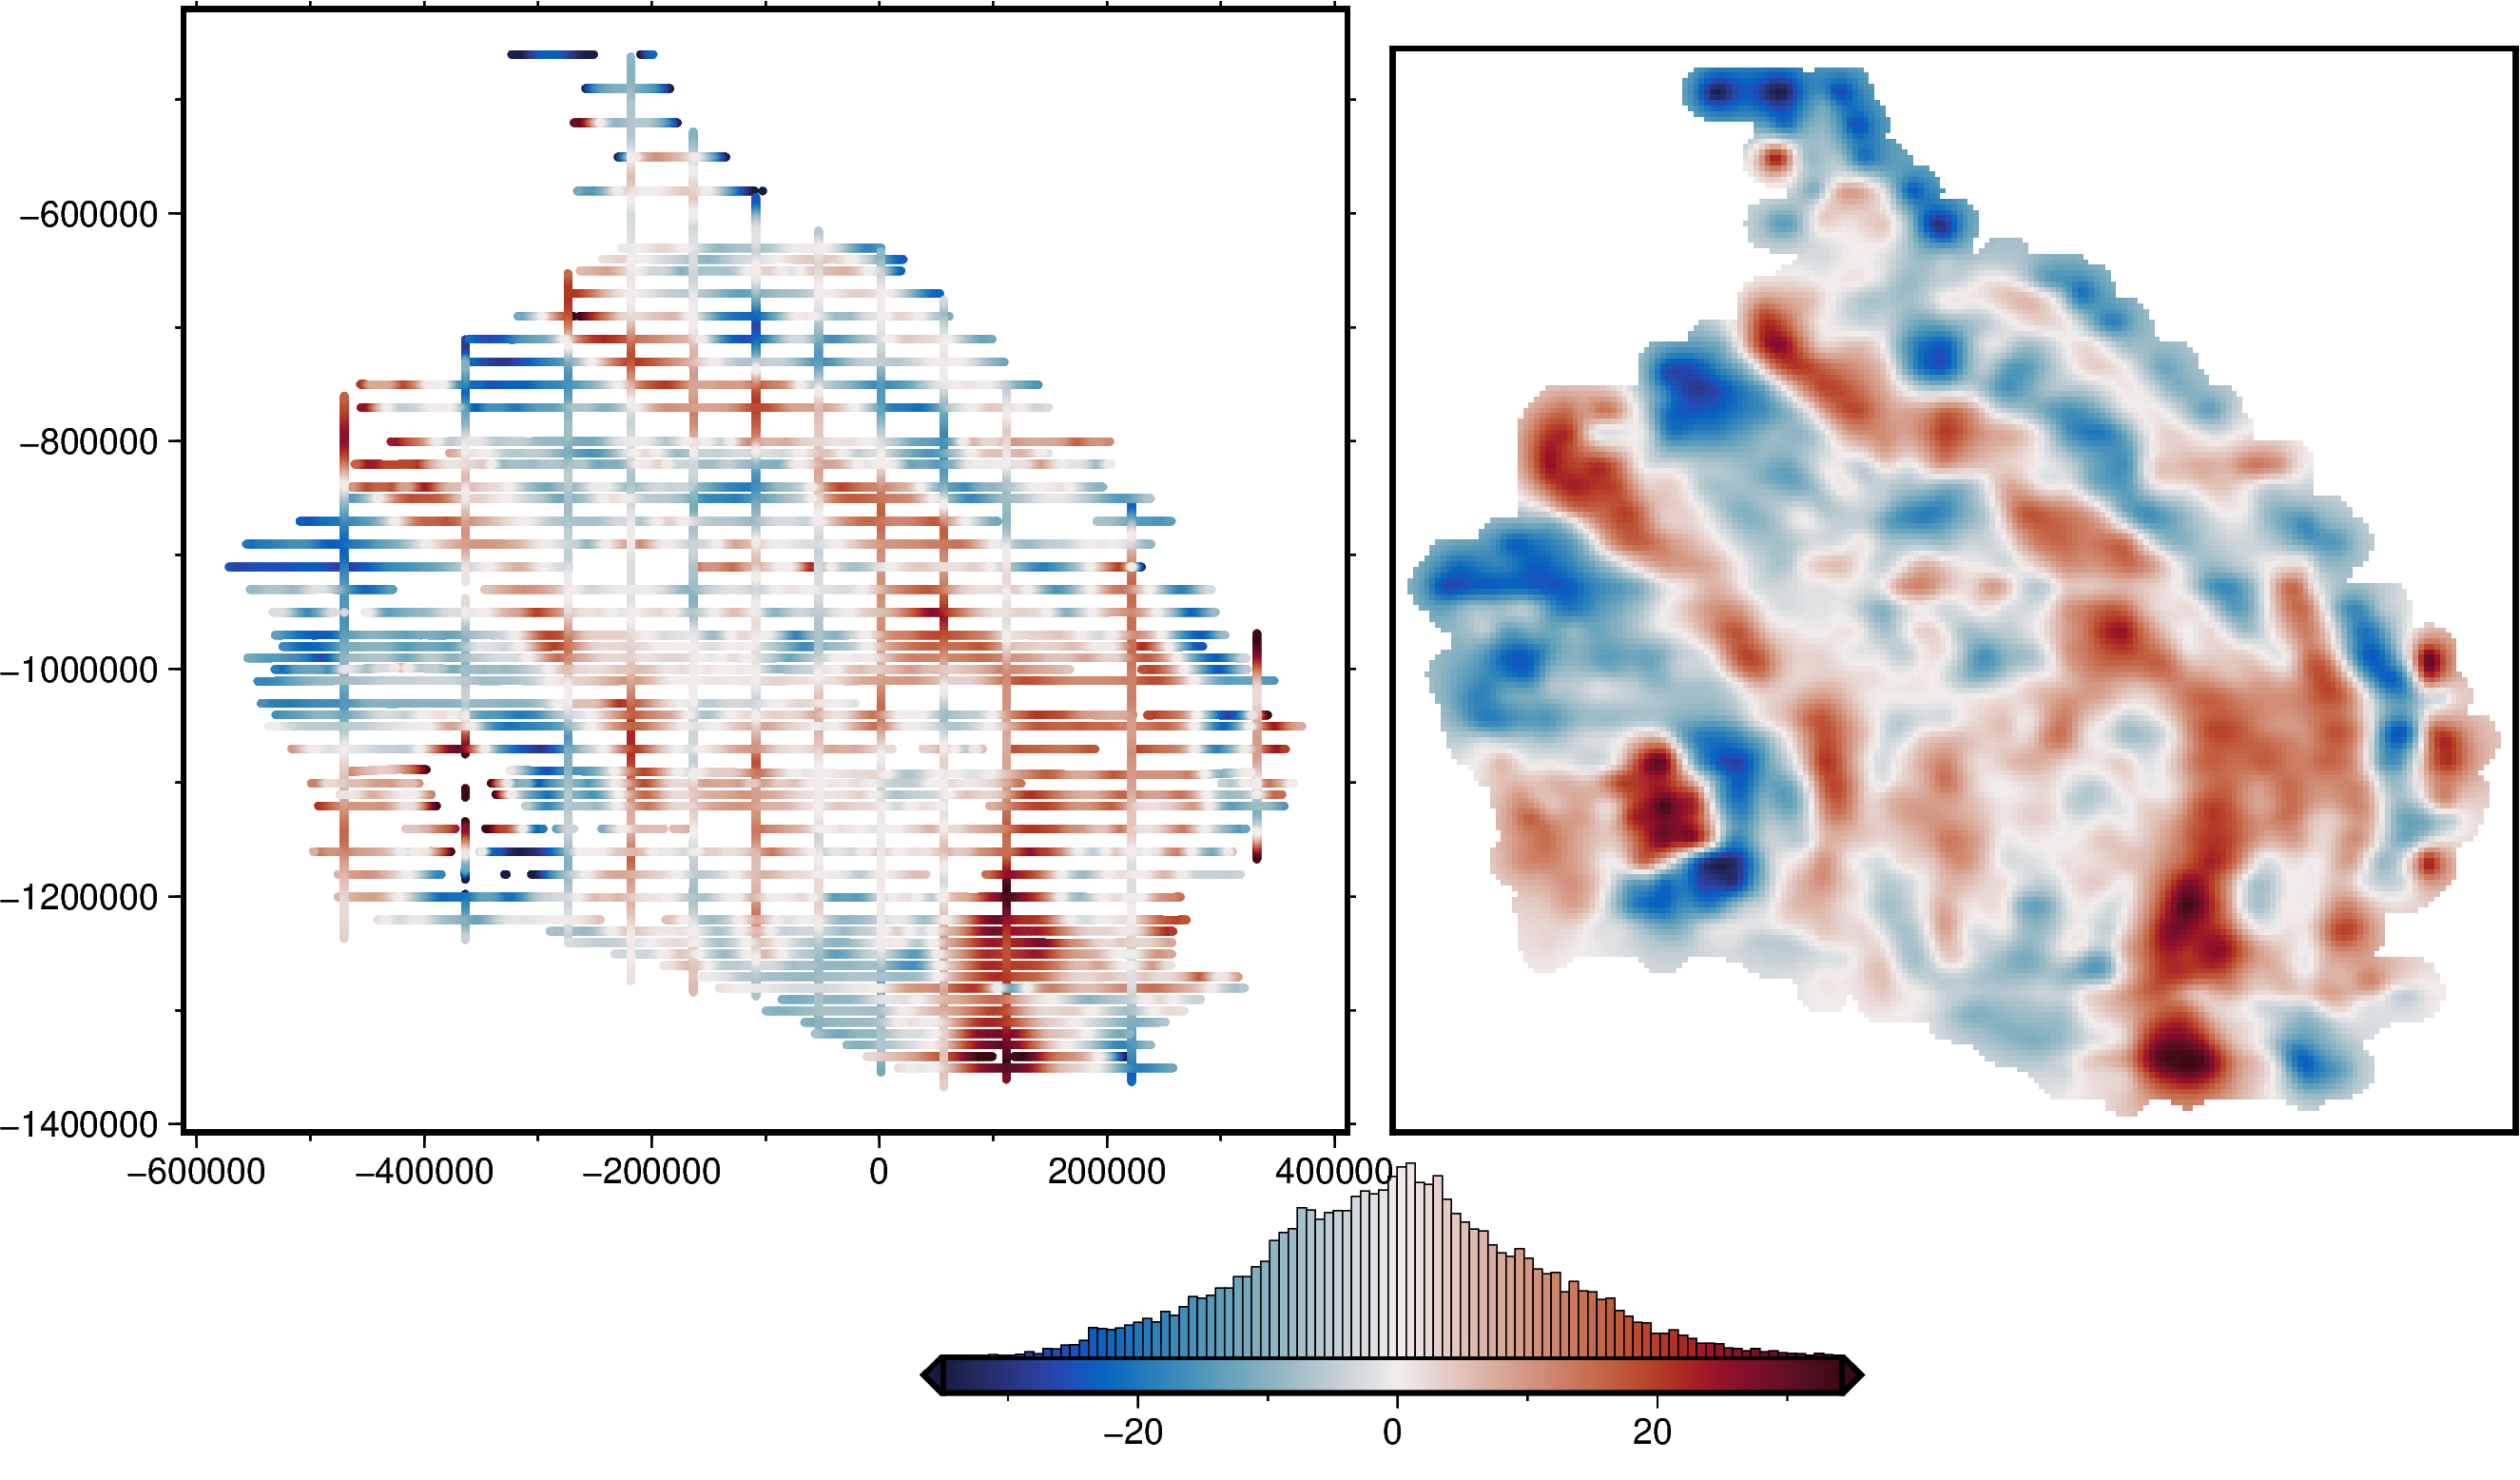

In [23]:
# set region
region = vd.pad_region(vd.get_region((df_cleaned.easting, df_cleaned.northing)), 40e3)


# plot gridded and masked gravity data
grav_grid = (
    grav_df[grav_df.test == False].set_index(["northing", "easting"]).to_xarray().Gobs
)

fig = maps.plot_grd(
    grav_grid,
    fig_width=10,
    region=region,
    cmap="balance+h0",
    hist=True,
    cbar_xoffset=-5,
    frame=["nESw"],
)


# plot a basemap
fig = maps.basemap(
    region=region, fig_height=10, fig=fig, origin_shift="xshift", xshift_amount=-1
)

# get a quarter of max absolute value and make a colorscale
# maxabs = vd.maxabs(df_cleaned.up_cont_grav) #* 0.25
# pygmt.makecpt(cmap="balance+h0", series=[-maxabs, maxabs])

# plot point gravity data
fig.plot(
    x=df_cleaned.easting,
    y=df_cleaned.northing,
    color=df_cleaned.up_cont_grav,
    style="c2p",
    cmap=True,
    frame=True,
)

# grav.plot_flightlines(
#     fig,
#     df_cleaned[df_cleaned.line<1000],
#     direction="EW",
#     plot_lines=False,
# )
# grav.plot_flightlines(
#     fig,
#     df_cleaned[df_cleaned.line>=1000],
#     direction="NS",
#     plot_lines=False,
# )


fig.show()

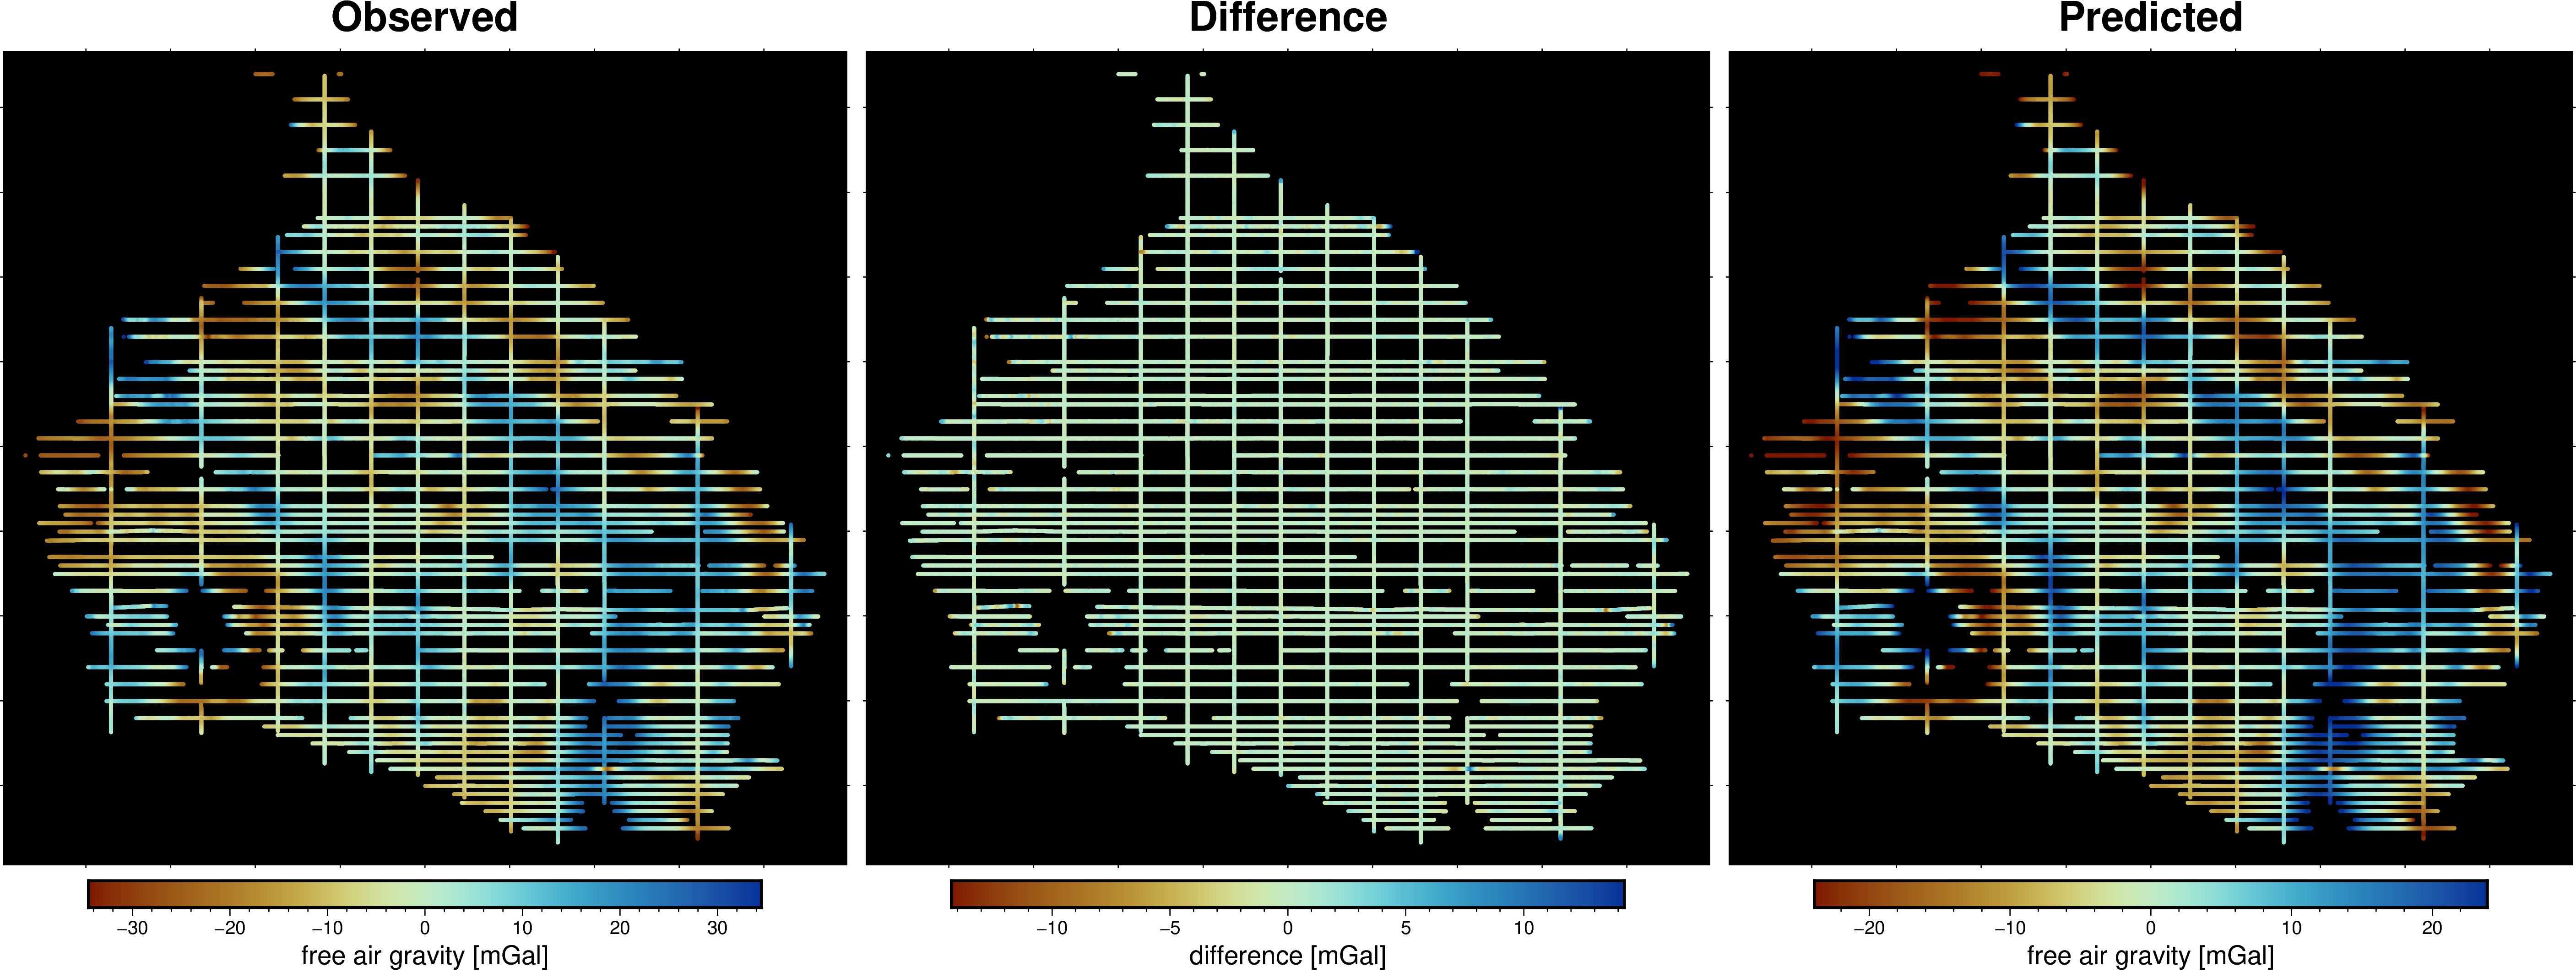

<Axes: >

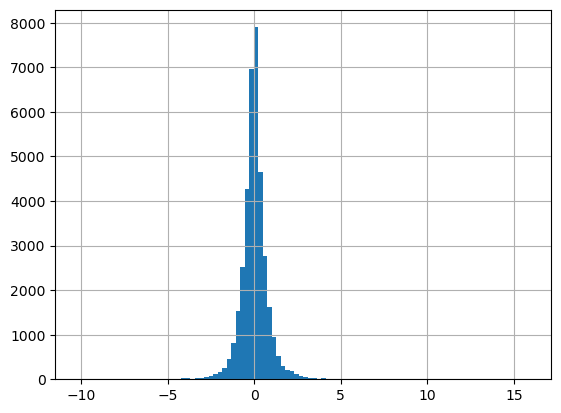

In [32]:
# plot a basemap
fig = maps.basemap(
    region,
    title="Observed",
    background="black",
)

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df_cleaned.FAG_levelled) * 0.9
pygmt.makecpt(cmap="roma", series=[-maxabs, maxabs])

# plot gravity data
fig.plot(
    x=df_cleaned.easting,
    y=df_cleaned.northing,
    color=df_cleaned.FAG_levelled,
    style="c2p",
    cmap=True,
)

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')


# add a second figure to the right
fig = maps.basemap(
    region,
    title="Difference",
    origin_shift="xshift",
    fig=fig,
    background="black",
)

# get a quarter of max absolute value and make a colorscale
dif = df_cleaned.up_cont_grav - df_cleaned.FAG_levelled
maxabs = vd.maxabs(dif) * 0.9
pygmt.makecpt(cmap="roma", series=[-maxabs, maxabs])

# plot gravity data
fig.plot(x=df_cleaned.easting, y=df_cleaned.northing, color=dif, style="c2p", cmap=True)

# plot the colorbar
fig.colorbar(frame='af+l"difference [mGal]"')


# plot a third figure
fig = maps.basemap(
    region,
    title="Predicted",
    origin_shift="xshift",
    fig=fig,
    background="black",
)

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df_cleaned.up_cont_grav) * 0.9
pygmt.makecpt(cmap="roma", series=[-maxabs, maxabs])

# plot gravity data
fig.plot(
    x=df_cleaned.easting,
    y=df_cleaned.northing,
    color=df_cleaned.up_cont_grav,
    style="c2p",
    cmap=True,
)

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')

fig.show()

dif.hist(bins=100)

compare with orginal grid

## compare upward continue amounts

In [14]:
# df_cleaned.elev.hist(bins=100)
# df_cleaned.elev.max()

In [15]:
# # Build the grid coordinates
# # region = vd.get_region(coordinates)

# low = 100
# grid_coords_low = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=low)
# high = 10e3
# grid_coords_high = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=high)

# # Grid the gravity disturbances
# grid_low = eqs_best.grid(grid_coords_low, data_names=["gravity_disturbance"])
# grid_high = eqs_best.grid(grid_coords_high, data_names=["gravity_disturbance"])

# grids = utils.grd_compare(
#     grid_low.gravity_disturbance,
#     grid_high.gravity_disturbance,
#     plot=True,
#     grid1_name=f"Continued to {low}m [mGal]",
#     grid2_name=f"Continued to {high}m [mGal]",
#     cmap="roma",
# )

In [16]:
# up_con_elev = 1e3
# grid_coords = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=up_con_elev)

# # Grid the gravity disturbances
# grid = eqs_best.grid(grid_coords, data_names=["Gobs"])
# grid = grid.reset_coords(names="upward")
# grid.Gobs.plot()
# grid

In [ ]:
# save to a .zarr file
grid.to_zarr(
    "../inversion_layers/rosetta_eq_source_1k_up_continued.zarr",
    encoding={
        "Gobs": {"compressor": zarr.Blosc()},
        "upward": {"compressor": zarr.Blosc()},
    },
    mode="w",
)

In [ ]:
rosetta_eq_source_1k_up_continued = xr.open_zarr(
    "../inversion_layers/rosetta_eq_source_1k_up_continued.zarr"
)
rosetta_eq_source_1k_up_continued

## mask grid

In [ ]:
up_con_elev = 1e3
grid_coords = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=up_con_elev)

# Grid the gravity disturbances
grid = eqs_best.grid(grid_coords, data_names=["Gobs"])
masked = vd.distance_mask((df_cleaned.x, df_cleaned.y), maxdist=20e3, grid=grid)
masked = masked.reset_coords(names="upward")
masked.Gobs.plot()

## save as .zarr

In [ ]:
# save to a .zarr file

masked.to_zarr(
    "../inversion_layers/rosetta_1k_up_continued_20k_masked.zarr",
    encoding={
        "Gobs": {"compressor": zarr.Blosc()},
        "upward": {"compressor": zarr.Blosc()},
    },
    mode="w",
)

# height = pygmt.grdsample(
#     grid=masked.height,
#     region=[-580000, 420000, -1420000, -420000],
#     registration="p",
#     spacing="5000+e",
#     # outgrid="gravity_data/rosetta_eq_source_up_continued_elev.nc",
# ).rename("z")

# gobs = pygmt.grdsample(
#     grid=masked.Gobs,
#     region=[-580000, 420000, -1420000, -420000],
#     registration="p",
#     spacing="5000+e",
#     # outgrid="rosetta_eq_source_up_continued_Gobs.nc",
# ).rename("gobs")

# # merge into a dataset
# output = xr.merge([gobs, height])

# # save to a .zarr file
# output.to_zarr(
#     "../inversion_layers/rosetta_eq_source_up_continued.zarr",
#     encoding={
#         "gobs": {"compressor": zarr.Blosc()},
#         "z": {"compressor": zarr.Blosc()},
#     },
#     mode="w",
# )

In [ ]:
rosetta_eq_source_up_continued = xr.open_zarr(
    "../inversion_layers/rosetta_1k_up_continued_masked.zarr"
)
rosetta_eq_source_up_continued

In [ ]:
fig = maps.subplots(
    [rosetta_eq_source_up_continued.upward, rosetta_eq_source_up_continued.Gobs],
    subplot_titles=["upward continued height", "observed gravity"],
)
fig.show()

## save as .csv

In [19]:
# # convert to a dataframe
# df = vd.grid_to_table(rosetta_eq_source_up_continued)

# # drop rows with nans
# df.dropna(inplace=True)

# # put into correct format for the inversion
# df.rename(
#     columns={"z": "ellipsoidal_elevation", "gobs": "free_air_anomaly"},
#     inplace=True,
# )

# df["lat"] = np.nan
# df["lon"] = np.nan
# df["station_ID"] = np.nan
# df["geoidal_elevation"] = np.nan
# df["elevation_error"] = np.nan
# df["observed_gravity"] = np.nan
# df["observed_gravity_error"] = np.nan
# df["gravity_disturbance"] = np.nan
# df["gravity_disturbance_error"] = np.nan
# df["free_air_anomaly_error"] = np.nan
# df["z_error"] = np.nan

# df = df[
#     [
#         "x",
#         "y",
#         "lat",
#         "lon",
#         "station_ID",
#         "ellipsoidal_elevation",
#         "geoidal_elevation",
#         "elevation_error",
#         "observed_gravity",
#         "observed_gravity_error",
#         "gravity_disturbance",
#         "gravity_disturbance_error",
#         "free_air_anomaly",
#         "free_air_anomaly_error",
#     ]
# ]
# df

In [ ]:
# df.dtypes

In [ ]:
# df = df.astype("float64")
# df.dtypes

In [ ]:
# df.to_csv(
#     "../rosetta_eq_source_up_continued.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )

In [ ]:
# check = pd.read_csv(
#     "../rosetta_eq_source_up_continued.csv.gz",
#     sep=",",
#     header="infer",
#     index_col=None,
#     compression="gzip",
# )
# check

In [ ]:
# df["free_air_anomaly"] -= df.free_air_anomaly.mean()
# df.describe()

In [ ]:
# df.set_index(["y", "x"]).to_xarray().free_air_anomaly.plot()

# Updated AntGG compilation

In [ ]:
# forsberg compilation
# includes AngGG, DTU Space, PolarGap, OIB,a ROSETTA, GOCE
# FA is free-air anom at geioid, DG is disturbance (FA at ellipsoid), BA is bouguer anom (free air at sea)
# antgg_update_tif = rioxarray.open_rasterio('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_fa.tif')
# file ='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_gravity.dat'
file = "/Volumes/arc_04/tankerma/Datasets/4D_antarctica_grav/ant4d_gravity/ant4d_gravity.dat"
antgg_update = pd.read_csv(
    file,
    delim_whitespace=True,
    skiprows=3,
    names=["id", "lat", "lon", "FA", "Err", "DG", "BA"],
)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
antgg_update["x"], antgg_update["y"] = transformer.transform(
    antgg_update.lat.tolist(), antgg_update.lon.tolist()
)

region = vd.get_region((antgg_update.x, antgg_update.y))
antgg_update.describe()

In [ ]:
antgg_update = pygmt.blockmedian(
    antgg_update[["x", "y", "FA"]],
    spacing="5000+e",
    region=(-3330000, 3330000, -3330000, 3330000),
)

# antgg_update = antgg_update.set_index(['x', 'y'])

# antgg_update=antgg_update[~antgg_update.index.duplicated()]
# # # antgg_update.to_xarray()
# xr.Dataset.from_dataframe(antgg_update)

fname = "gravity_data/ant4d_gravity_epsg_5k.nc"
pygmt.surface(
    data=antgg_update[["x", "y", "FA"]],
    spacing=5000,
    region=(-3330000, 3330000, -3330000, 3330000),
    M="2c",
    outgrid=fname,
)
# antgg_update_tif
# pygmt.grdfill(grid=antgg_update_grid, mode='n', L=True, region=fig_reg)#, outgrid=fname)

In [ ]:
start_fig()
fname = "/Volumes/arc_04/tankerma/Datasets/4D_antarctica_grav/ant4d_gravity/ant4d_gravity_epsg_5k.nc"
# make color ramp scaled to points
pygmt.grd2cpt(cmap="jet", continuous=True, region=fig_reg, grid=fname)
# pygmt.makecpt(cmap="viridis", series=[antgg_update.FA.min(), antgg_update.FA.max()])

# plot grid
fig.grdimage(
    grid=fname,
    cmap=True,
    projection=fig_proj,
    region=fig_reg,
    frame=["a", "+gwhite"],
)

fig.colorbar(frame='af+l"observed gravity [mGal]"')

fig.show()

# Ground Surveys

In [ ]:
# from 2019/2020 KIS survey
file = "C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/K863_KIS.csv"
KIS = pd.read_csv(file)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
KIS["x"], KIS["y"] = transformer.transform(
    KIS.Latitude.tolist(), KIS.Longitude.tolist()
)

KIS

In [ ]:
df = KIS
buffer = 10e3
n = df.y.min() - buffer
s = df.y.max() + buffer
e = df.x.min() - buffer
w = df.x.max() + buffer

df = rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

KIS["FA_shift"] = KIS.FA + (df.FA.mean() - KIS.FA.mean())

In [ ]:
df = KIS
buffer = 80e3
n = df.y.min() - buffer
s = df.y.max() + buffer
e = df.x.min() - buffer
w = df.x.max() + buffer

start_fig(n=n, s=s, e=e, w=w)


df = KIS
# make color ramp scaled to points
pygmt.makecpt(
    cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True
)

# plot points
fig.plot(
    x=df.x,
    y=df.y,
    color=df.FA_shift,
    style="c4p",
    projection=fig_proj,
    region=fig_reg,
    cmap=True,
)

df = rosetta_block

# plot points
fig.plot(
    x=df.x,
    y=df.y,
    color=df.FA,
    style="c4p",
    projection=fig_proj,
    region=fig_reg,
    cmap=True,
)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show()

In [ ]:
# from 2021/2022 Disco Deep survey
file = "C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/K863_DD_2feb22.csv"
DD = pd.read_csv(file)
DD.drop(columns=["Free air anomaly", "Free air effect"], inplace=True)
DD["FA"] = DD["Absolute Gravity"] - DD["Ellipsoidal gravity"] + (DD.Elevation * 0.3086)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
DD["x"], DD["y"] = transformer.transform(DD.Latitude.tolist(), DD.Longitude.tolist())
DD

In [ ]:
df = DD
buffer = 10e3
n = df.y.min() - buffer
s = df.y.max() + buffer
e = df.x.min() - buffer
w = df.x.max() + buffer

df = rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

DD["FA_shift"] = DD.FA + (df.FA.mean() - DD.FA.mean())

start_fig(n=n, s=s, e=e, w=w)


df = DD
# make color ramp scaled to points
pygmt.makecpt(
    cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True
)

# plot points
fig.plot(
    x=df.x,
    y=df.y,
    color=df.FA_shift,
    style="c4p",
    projection=fig_proj,
    region=fig_reg,
    cmap=True,
)

df = rosetta_block

# plot points
fig.plot(
    x=df.x,
    y=df.y,
    color=df.FA,
    style="c4p",
    projection=fig_proj,
    region=fig_reg,
    cmap=True,
)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show()

In [ ]:
# from Atsu Muto
file = "C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/wgz_fa.csv"
WGZ = pd.read_csv(file)
WGZ.rename(
    columns={"free-air_disturbance(mGal)": "FA", "PSX(m)": "x", "PSY(m)": "y"},
    inplace=True,
)
# transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
# WGZ['x'], WGZ['y'] = transformer.transform(WGZ.Latitude.tolist(), WGZ.Longitude.tolist())
WGZ

In [ ]:
df = WGZ
buffer = 20e3
n = df.y.min() - buffer
s = df.y.max() + buffer
e = df.x.min() - buffer
w = df.x.max() + buffer

df = rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

WGZ["FA_shift"] = WGZ.FA + (df.FA.mean() - WGZ.FA.mean())

start_fig(n=n, s=s, e=e, w=w)


df = WGZ
# make color ramp scaled to points
pygmt.makecpt(
    cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True
)

# plot points
fig.plot(
    x=df.x,
    y=df.y,
    color=df.FA_shift,
    style="c4p",
    projection=fig_proj,
    region=fig_reg,
    cmap=True,
)

df = rosetta_block

# plot points
fig.plot(
    x=df.x,
    y=df.y,
    color=df.FA,
    style="c4p",
    projection=fig_proj,
    region=fig_reg,
    cmap=True,
)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show()